In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '../..'))
	print(os.getcwd())
except:
	pass


In [1]:
import time

class Timing():
    def __init__(self):
        self.now = None
        self.task = None
    def start(self, task):
        # task should be a printable object, i.e. a string
        self.task = task
        self.now = time.process_time()
    def time_str(self, time):
        if (time > 60):
            return str(round(time/60, 2)) + "m"
        elif (time > 1):
            return str(round(time,2)) + "s"
        else:
            return str(round(time*1000, 2)) + "ms"
    def end(self):
        if self.now == None:
            return None
        else:
            delta = time.process_time() - self.now
            print("{:<8} required for [{}]".format(self.time_str(delta), self.task))

t = Timing()

t.start("Import TensorFlow")
import tensorflow as tf
t.end()
t.start("Other package imports")
# you can import tensorflow.keras or tensorflow.keras.python for the same outcome
# VS Code's linting has some problems with tensorflow.keras, so I used the other import
from tensorflow.python.keras import datasets, layers, models, backend
import matplotlib.pyplot as plt 
import numpy as np
import random
t.end()


2.51s    required for [Import TensorFlow]
0.16ms   required for [Other package imports]


In [2]:
t.start("Load MNIST Data")
(train_pics, train_labels), (test_pics, test_labels) = datasets.mnist.load_data()
train_pics = train_pics[:10000]
train_labels = train_labels[:10000]
test_pics = test_pics[:1000]
test_labels = test_labels[:1000]
t.end()
train_pics, test_pics = train_pics / 255, test_pics / 255


540.17ms required for [Load MNIST Data]


Number of training pictures: 10000, Number of testing pictures: 1000
Data type: <class 'numpy.float64'>
Largest value in data set: 1.0
Displaying items [741, 8917, 9368, 7390, 784, 5406, 2554, 7243, 3640] from the training pictures.
249.06ms required for [Plotting 9 random samples]
1.28s    required for [Rendering samples with matplotlib]


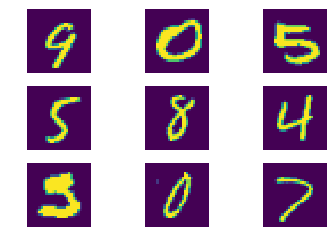

In [3]:
def explore_dataset():
    print("Number of training pictures: {}, Number of testing pictures: {}".format(
        len(train_pics), len(test_pics)
    ))
    """ The training data is originally stored as 8 bit integers via numpy,
    but the division by 255 converts them into floats """
    print("Data type: {}".format(type(train_pics[0][0][0])))
    """ The max value for an 8 bit unsigned integer is 255"""
    print("Largest value in data set: {}".format(np.amax(train_pics)))

def preview(n):
    """ Take n^2 random items from the sample and visualize them. n must be less than 10 """
    assert n < 10 and n > 0 and int(n) == n
    random_indices = random.sample(range(0, len(train_pics)), n**2)
    print("Displaying items {} from the training pictures.".format(random_indices))

    fig = plt.figure()
    t.start("Plotting {} random samples".format(n**2))
    for i, pic_idx in enumerate(random_indices):
        a = fig.add_subplot(n,n,i+1) # number of rows, columns, then index
        plt.axis('off')
        plt.imshow(train_pics[pic_idx])
    t.end()
    t.start("Rendering samples with matplotlib")
    plt.show()
    t.end()

explore_dataset()
preview(3)


In [4]:
""" Using the keras API to define the model and each layer """
model = models.Sequential()
""" the Conv2D layer is a predefined layer from the keras API. All layers are by definition
differentiable, and backpropagation can be carried out to train any sequence of layers in a 
model."""
model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D(3,3))
model.add(layers.Conv2D(16, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(16, (2,2), activation='relu'))
# summary for convolution section
print("CONVOLUTION SUMMARY")
model.summary()

""" The output shape of each layer so far has been 3D. You can flatten it
by adding a flatten layer, which will convert the model to a 1D vector.
Then, dense layers are addded in which the number of parameters is
the product of the input dimensions and output dimensions -- every possible
connection between nodes exists and is differentiable """
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
# the final layer should have dimension of 10, since there are 10 possible classifcations
model.add(layers.Dense(10, activation='softmax'))
print("COMPLETE SUMMARY")
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
CONVOLUTION SUMMARY
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 16)          2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 16)          1040      
Total params: 3,520
Trainable params: 3,520
Non-trainable params: 0
_________________________________________________________________
COMPLETE SUMMARY
_______________________________

In [5]:
model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
train_pics = train_pics.reshape((10000, 28, 28, 1))
model.fit(train_pics, train_labels, epochs=3)


Epoch 1/3
10000/10000 [==============================] - 4s 436us/sample - loss: 0.9857 - acc: 0.6917
Epoch 2/3
10000/10000 [==============================] - 4s 379us/sample - loss: 0.2813 - acc: 0.9135
Epoch 3/3
10000/10000 [==============================] - 4s 404us/sample - loss: 0.1871 - acc: 0.9450


In [6]:
# evalutate against test data
test_pics = test_pics.reshape((1000,28,28,1))
test_locc, test_accuracy = model.evaluate(test_pics, test_labels)
print(test_accuracy)


1000/1000 [==============================] - 0s 342us/sample - loss: 0.1935 - acc: 0.9290
0.929


Original dimensions of layer: (26, 26, 16)
Array of each channel: (16, 26, 26)
Final prediction: 1
The prediction was correct!


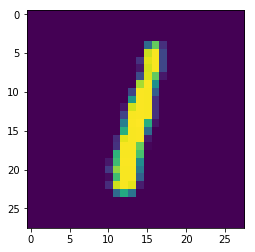

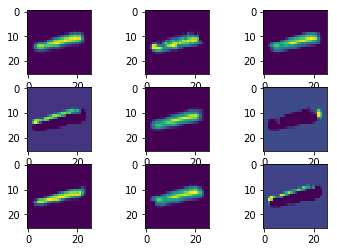

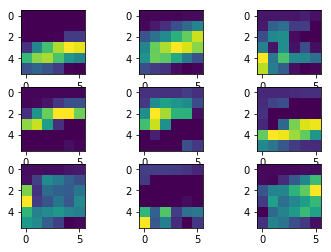

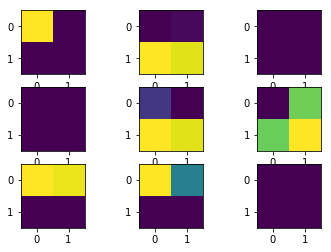

In [7]:
""" See what the model is thinking """
def nth_layer_output(n, x):
    x = x.reshape(1, 28,28,1)
    """ what the nth layer of the model evaluates for input x """
    f = backend.function(
        [model.layers[0].input],
        [model.layers[n-1].output]
    )
    return np.squeeze(f([x])[0])

def plot_pic(pic):
    pic = np.squeeze(pic)
    fig = plt.figure()
    plt.imshow(pic)
    plt.show()

def plot_channels(channel_2d):
    # there are 16 channels
    # we will just plot the first 9 to save time
    fig = plt.figure()
    for i, channel in enumerate(channel_2d):
        a = fig.add_subplot(3,3,i+1)
        plt.imshow(channel)
        if i == 8:
            break
    plt.show()

def plot_all_for_pic(pic_i):
    output = nth_layer_output(1, test_pics[pic_i])
    print("Original dimensions of layer: {}".format(output.shape))
    output = np.swapaxes(output, 2, 0)
    print("Array of each channel: {}".format(output.shape))
    plot_pic(test_pics[pic_i])
    plot_channels(output)

    output = nth_layer_output(3, test_pics[pic_i])
    output = np.swapaxes(output, 2, 0)
    plot_channels(output)

    output = nth_layer_output(5, test_pics[pic_i])
    output = np.swapaxes(output, 2, 0)
    plot_channels(output)

    """ print the prediction of the model
    the 8th layer is the final layer, with 10 weights to classify the
    10 possible digits. Return the index of the max value """
    prediction = np.argmax(nth_layer_output(8, test_pics[pic_i]))
    print("Final prediction: {}".format(
        prediction
    ))
    if test_labels[pic_i] == prediction:
        print("The prediction was correct!")
    else:
        print("The prediction was incorrect. SAD!")

plot_all_for_pic(random.randint(0, len(test_pics)))